In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import pickle
import os

In [2]:
df = pd.read_pickle('./engineeredFeatureDF.pkl')
train = df.loc[(df.date < "2013-07-31"), :]
val = df.loc[(df.date >= "2013-07-31" ) & (df.date < "2017-08-16")]

cols = [col for col in train.columns if col not in ['date', 'sales', 'transactions' ]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

del df

In [3]:
def rlsme(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    preds[np.where(preds < 0)] = 0
    loss_val = np.sum(np.square((np.log(1+preds) - np.log(1 + target)))) / n
    return np.sqrt(loss_val)


def lgbm_rlsme(preds, train_data):
    labels = train_data.get_label()
    loss = rlsme(preds, labels)
    return "RMSLE", loss, False

# Loss Functions
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(preds, labels)
    return 'SMAPE', smape_val, False


def rmsle_lgbm(y_pred, data):
    y_true = np.array(data.get_label())
    score = np.sqrt(np.mean(np.power(np.log1p(y_true) - np.log1p(y_pred), 2)))
    return 'rmsle', score, False

# Plotting and post processing functions
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show(block=True)
    else:
        print(feat_imp.head(num))
    return feat_imp

In [4]:
# lgb_params = {'num_leaves': 50,
#               'learning_rate': 0.02,
#               'feature_fraction': 0.8,
#               'max_depth': 30,
#               'verbose': 0,
#               'num_boost_round': 20000,
#               'early_stopping_rounds': 400,
#               'nthread': -1}
lgb_params = {'num_leaves': 20,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 10,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 200,
              'nthread': -1}

trial_num = 'trial_12'
os.makedirs(f'models/{trial_num}', exist_ok=True)
pickle.dump(lgb_params, open(f"models/{trial_num}/params.dat", 'wb'))

In [5]:
lgbtrain_smape = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval_smape = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain_smape, feature_name=cols)

lgbtrain_rlsme = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval_rlsme = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain_rlsme, feature_name=cols)

LightGBM -- Setup

In [6]:
# model_smape = lgb.train(lgb_params, lgbtrain_smape,
#                   valid_sets=[lgbtrain_smape, lgbval_smape],
#                   num_boost_round=lgb_params['num_boost_round'],
#                 #   callbacks=[lgb.early_stopping(stopping_rounds=200)],
#                   feval=lgbm_smape,
#                   verbose_eval=100)

# pickle.dump(model_smape, open(f"models/{trial_num}/lgbm_smape_1.dat",'wb'))

In [7]:
model_rlsme = lgb.train(lgb_params, lgbtrain_rlsme,
                  valid_sets=[lgbtrain_rlsme, lgbval_rlsme],
                  num_boost_round=lgb_params['num_boost_round'],
                #   callbacks=[lgb.early_stopping(stopping_rounds=200)],
                  feval=lgbm_rlsme,
                  verbose_eval=100)

pickle.dump(model_rlsme, open(f"models/{trial_num}/lgbm_rlsme_1.dat",'wb'))

/home/arlamb/anaconda3/envs/cs567/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/arlamb/anaconda3/envs/cs567/lib/python3.9/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152562 seconds.
You can set `force_col_wise=true` to remove the overhead.


/home/arlamb/anaconda3/envs/cs567/lib/python3.9/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/arlamb/anaconda3/envs/cs567/lib/python3.9/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 200 rounds
[100]	training's RMSLE: 2.61967	valid_1's RMSLE: 2.28122
[200]	training's RMSLE: 1.61964	valid_1's RMSLE: 2.00554
[300]	training's RMSLE: 1.0817	valid_1's RMSLE: 1.80842
[400]	training's RMSLE: 0.85253	valid_1's RMSLE: 1.69615
[500]	training's RMSLE: 0.761947	valid_1's RMSLE: 1.46851
[600]	training's RMSLE: 0.722383	valid_1's RMSLE: 1.28696
[700]	training's RMSLE: 0.695247	valid_1's RMSLE: 1.19673
[800]	training's RMSLE: 0.673631	valid_1's RMSLE: 1.23307
[900]	training's RMSLE: 0.660492	valid_1's RMSLE: 1.23577
Early stopping, best iteration is:
[742]	training's RMSLE: 0.684257	valid_1's RMSLE: 1.19444


In [8]:
# y_pred_val_smape = model_smape.predict(X_val, num_iteration=model_smape.best_iteration)
y_pred_val_rlsme = model_rlsme.predict(X_val, num_iteration=model_rlsme.best_iteration)

In [9]:
# smape(y_pred_val, Y_val)
# smape(y_pred_val_smape, Y_val)

In [10]:
# plot_lgb_importances(model_smape, num=30, plot=True)

In [11]:
rlsme(y_pred_val_rlsme, Y_val)

1.1944449065848002

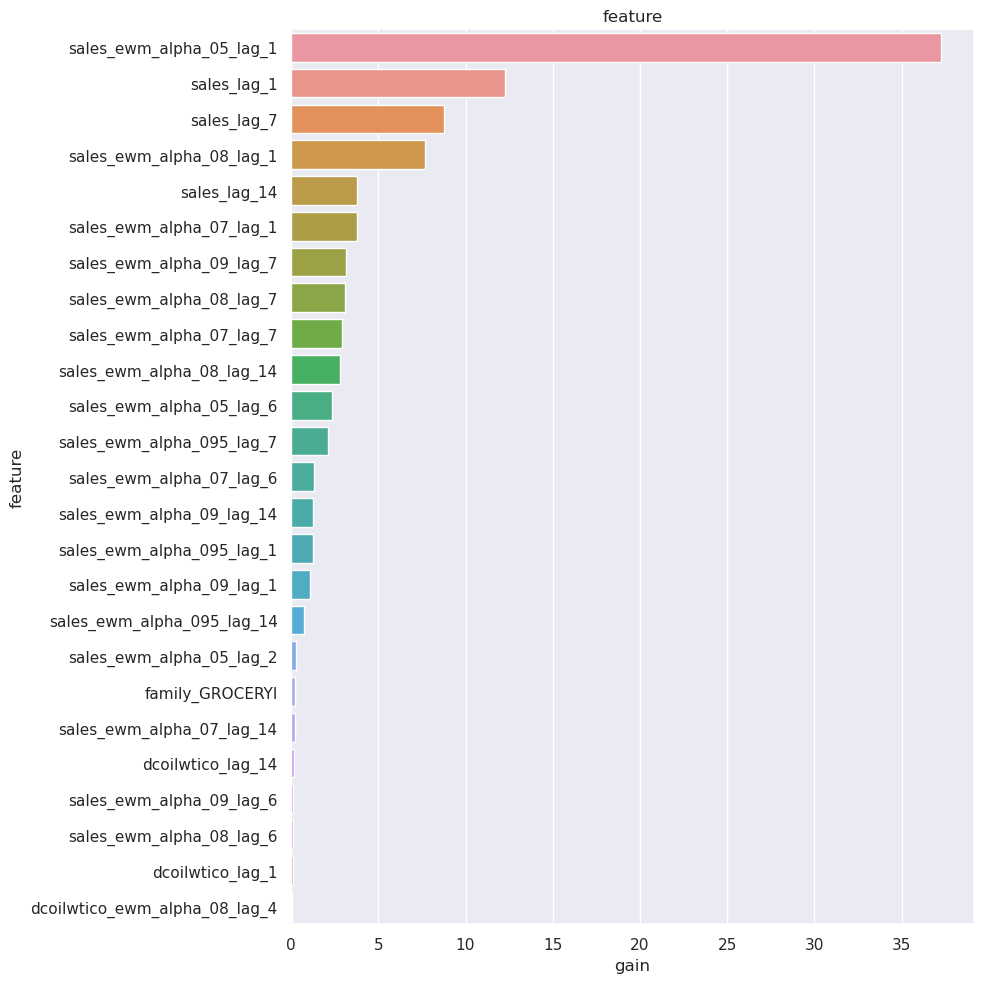

,feature,split,gain
86,sales_ewm_alpha_05_lag_1,302,37.283794
8,sales_lag_1,436,12.242966
14,sales_lag_7,608,8.777188
56,sales_ewm_alpha_08_lag_1,128,7.664450
21,sales_lag_14,597,3.797199
...,...,...,...
347,family_CELEBRATION,0,0.000000
345,family_BOOKS,0,0.000000
301,store_nbr_22,0,0.000000
343,family_BEAUTY,0,0.000000


In [12]:
plot_lgb_importances(model_rlsme, num=30, plot=True)

In [13]:
feat_imp_rmsle = plot_lgb_importances(model_rlsme, num=200)

low_importance_rmsle = feat_imp_rmsle[feat_imp_rmsle["gain"] <= 0.005]["feature"].values

df = pd.read_pickle('engineeredFeatureDF.pkl')
df = df.drop(low_importance_rmsle, axis=1)

cols_dff = [col for col in df.columns if col not in ['date', "sales", "year"]]

                       feature  split       gain
86    sales_ewm_alpha_05_lag_1    302  37.283794
8                  sales_lag_1    436  12.242966
14                 sales_lag_7    608   8.777188
56    sales_ewm_alpha_08_lag_1    128   7.664450
21                sales_lag_14    597   3.797199
..                         ...    ...        ...
114              ma_oil_lag_14     24   0.004574
25         sales_roll_mean_546     25   0.004546
142  ma_oil_ewm_alpha_09_lag_9      5   0.004527
81   sales_ewm_alpha_07_lag_11     30   0.004325
332               store_nbr_50     39   0.004290

[200 rows x 3 columns]


In [14]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols_dff]


test = df.loc[df.date >= "2017-08-16"]
X_test = test[cols_dff]
# X_test.sales = np.nan

Y_train.shape, X_train.shape, X_test.shape

((3000888,), (3000888, 191), (28512, 191))

In [15]:
# lgb_params = {'num_leaves': 10,
#               'learning_rate': 0.02,
#               'feature_fraction': 0.8,
#               'max_depth': 5,
#               'verbose': 0,
#               'nthread': -1,
#               "num_boost_round": model_rlsme.best_iteration}
lgb_params["num_boost_round"] = model_rlsme.best_iteration
lgb_params["early_stopping_rounds"] = 0

In [16]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols_dff)

In [ ]:
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model_rlsme.best_iteration)

In [ ]:
test_preds = final_model.predict(X_test, num_iteration=model_rlsme.best_iteration)

In [ ]:
test_preds

In [ ]:
test_preds[test_preds < 0] = 0

In [ ]:
# Create submission
path = 'inputs/'
df_sub = pd.read_csv(path + 'sample_submission.csv', index_col='id')
df_sub.sales = test_preds
df_sub.to_csv('submission.csv', index=True)